# Wärme Rohr 1D 24.07.2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math 
from objdict import ObjDict
from FEMesh import *
from functions import *
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2


## Numerische Lösung 

\begin{aligned}
& C \times v \times \sum_{\mathrm{j}} \int_0^1 \varphi_{\mathrm{j}} \times \varphi_{\mathrm{i}} d x \times \mathrm{T}_{\mathrm{j}}(t)+\mathrm{C} \times \mathrm{v} \times \sum_{\mathrm{j}} \int_0^1 \varphi_{\mathrm{j}} \times \varphi_{\mathrm{i}} \mathrm{dx} \times \mathrm{T}_{\mathrm{j}}(\mathrm{t})+\alpha \times \varphi_{\mathrm{i}}(0) \times \\
& \varphi_{\mathrm{j}}(0) \times \mathrm{T}_{\mathrm{j}}(\mathrm{t})=\alpha \times \widehat{\mathrm{T}} \times \varphi_{\mathrm{i}}(0)+\mathrm{q} \times \int_0^1 \varphi_{\mathrm{i}} \mathrm{dx}
\end{aligned}


\begin{gathered}
Gleichung: \mathrm{M} \times \mathrm{T}+\mathrm{A} \times \mathrm{T}=\mathrm{r} \\
\\
Mit: \\
\mathrm{M}_{\mathrm{ij}}=\int \varphi_{\mathrm{j}} \times \varphi_{\mathrm{i}} \\
\mathrm{A}_{\mathrm{ij}}=\int \varphi_{\mathrm{i}} \times \varphi_{\mathrm{j}}^{\prime} \mathrm{dx}+\alpha \times \mathrm{S}_{\mathrm{ij}} \\
\mathrm{S}_{\mathrm{ij}}=1(\text { for } \mathrm{i}=\mathrm{j}=1) \\
\mathrm{S}_{\mathrm{ij}}=0
\end{gathered}

## Programmierung der numerischen 1D Lösung 

### Funktionen

In [3]:
def compute_M(n, l, C):
    M = np.zeros((n, n))
    h = l / (n - 1)
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i, j] = C * h / 3
            if abs(i - j) == 1:
                M[i, j] = C * h / 6
    return M

def compute_A(n, l, C, v, alpha):
    A = np.zeros((n, n))
    h = l / (n - 1)
    for i in range(n):
        for j in range(n):
            if i == j:
                A[i, j] = C * v / h + (alpha if i == 0 and j == 0 else 0)
            if abs(i - j) == 1:
                A[i, j] = -C * v / h / 2
    return A

def compute_S(n, alpha):
    S = np.zeros((n, n))
    S[0, 0] = alpha
    return S

def compute_r(n, l, q, T0, alpha):
    r = np.zeros(n)
    r[0] = alpha * T0
    h = l / (n - 1)
    for i in range(n):
        r[i] += q * h / 2  
    return r

### Temperatur über Zeit

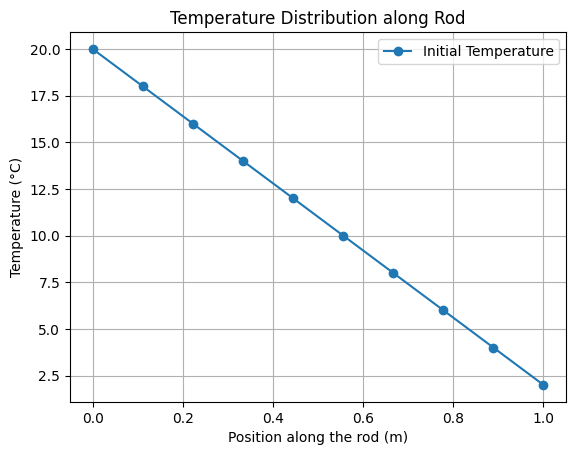

In [7]:
A = 0.00114  # m^2
c = 4190     # SHC J/kg*K
rho = 1000   # kg/m^3
C = A * rho * c #Simplify
alpha = 1e10 # Penalty factor
q = 100      # Heat flow W/m
v = 1        # Velocity m/s
l = 1        # Rod Length
n = 10       # Nodes

M = compute_M(n, l, C)
A = compute_A(n, l, C, v, alpha)
r = compute_r(n, l, q, 20, alpha)
S = compute_S(n,alpha)

#print('M =\n',M)
#print('A =\n',A)
#print('r =\n',r)
#print('M =\n',M)


T = np.zeros(n)
T[0] = 20  # Initial condition at x = 0, 20 degrees Celsius

x = np.linspace(0, l, n)  # Node positions along the rod
T = np.linalg.solve(A, r)

plt.plot(x, T, label='Initial Temperature', marker='o')
plt.title('Temperature Distribution along Rod')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

## Instationärer Fall Implizit Euler

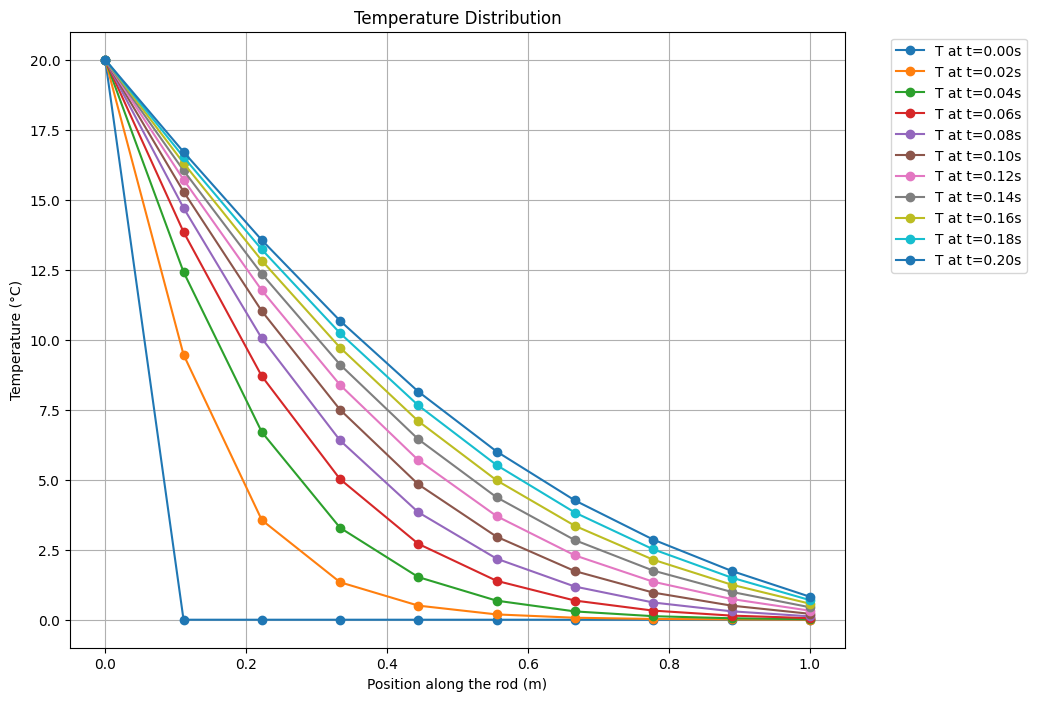

In [13]:
dt = 0.02
time = 0.2
n_steps = int(time / dt) 

T = np.zeros(n)
T[0] = 20  # Initial condition 
temperature_profile = np.zeros((n_steps + 1, n))
temperature_profile[0, :] = T


for step in range(1, n_steps + 1):
    gleichung_links = M + dt * A  
    gleichung_rechts = M @ T + dt * r 
    T = np.linalg.solve(gleichung_links, gleichung_rechts)  
    temperature_profile[step, :] = T  #store result

x = np.linspace(0, l, n)  #node Positions

plt.figure(figsize=(10, 8))
for i in range(n_steps + 1):
    plt.plot(x, temperature_profile[i, :], label=f'T at t={i*dt:.2f}s', marker='o')
plt.title('Temperature Distribution')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

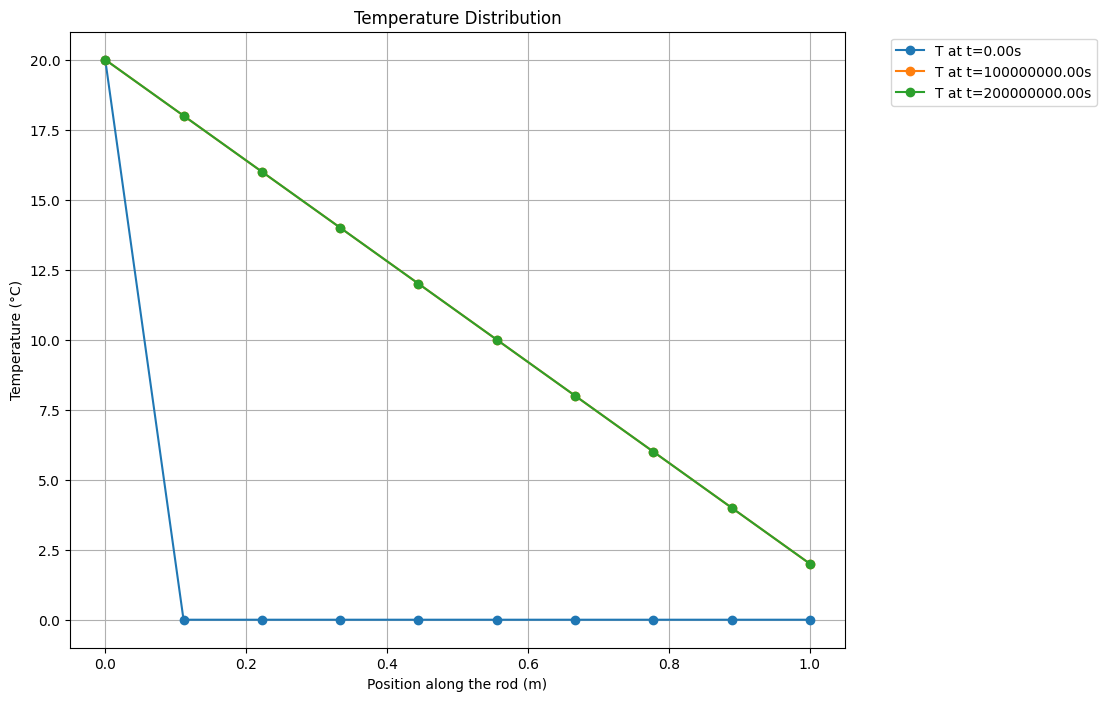

In [17]:
dt = 100000000
time = 200000000
n_steps = int(time / dt) 

T = np.zeros(n)
T[0] = 20  # Initial condition 
temperature_profile = np.zeros((n_steps + 1, n))
temperature_profile[0, :] = T


for step in range(1, n_steps + 1):
    gleichung_links = M + dt * A  
    gleichung_rechts = M @ T + dt * r 
    T = np.linalg.solve(gleichung_links, gleichung_rechts)  
    temperature_profile[step, :] = T  #store result

x = np.linspace(0, l, n)  #node Positions

plt.figure(figsize=(10, 8))
for i in range(n_steps + 1):
    plt.plot(x, temperature_profile[i, :], label=f'T at t={i*dt:.2f}s', marker='o')
plt.title('Temperature Distribution')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()